In [ ]:
from pathlib import Path
drive_dir = Path("../")

import sys
import os
module_path = os.path.abspath(str(drive_dir))
sys.path.insert(0, module_path)

import pandas as pd

import pathlib
from pathlib import Path
import seaborn as sns

import katspace
import katspace.core
import katspace.data
import katspace.plot


import importlib
for mod in ["katspace.core", "katspace.data", "katspace.plot"]:
    importlib.reload(sys.modules[mod])

from katspace.data import non_empty_labels_from_iter
from katspace.plot import beginning_history_preprocess, calculate_ratios2

import matplotlib.pyplot as plt

def get_years_dict(df):
    temp_df = df.set_index("filename")["year"]
    years = temp_df.to_dict()
    return years

data_dir = Path(drive_dir, "data-test/")
results_dir = Path(data_dir, "results/predict-286-gutenberg/")

space_types = ("perceived_space", "action_space", "visual_space", "descriptive_space", "no_space")
notebooks_dir =  Path(drive_dir, "notebooks/")

space_types = ("perceived_space", "action_space", "visual_space", "descriptive_space", "no_space")

canon_df = pd.read_excel(Path(data_dir, "20240818_canon_master_merged.xlsx", index = 0))
canon_df = canon_df.drop(canon_df[canon_df["total"] == 0].index)
canon_df[canon_df["total"] == 0]

years = get_years_dict(canon_df.query("year > 1780 and year < 1940"))

In [2]:
from pandas.io.parquet import read_parquet

fp_labels_df = Path(data_dir, "results/2025_02_05_labels_df_canon.parquet")
results_canon = read_parquet(fp_labels_df)
results_canon = {filename: list(non_empty_labels_from_iter(iter(results_canon[filename]))) for filename in results_canon.columns}


In [ ]:
df = beginning_history_preprocess(results_canon, chunk_size = 15, years = years, return_df = True)
df["no_space"] = df["total"] - df["all_space"]
df = calculate_ratios2(df, insert_values=True, suffix="")
df

,filename,total,perceived_space,action_space,visual_space,descriptive_space,all_space,no_space
year,,,,,,,,
1842,Alexis_Willibald_Der-falsche-Woldemar_1842,15,0.600000,0.000000,0.000000,0.000000,0.600000,0.400000
1852,Alexis_Willibald_Ruhe-ist-die-erste-Buergerpfl...,15,0.000000,0.133333,0.000000,0.000000,0.133333,0.866667
1840,Alexis_Willibald_Der-Roland-von-Berlin_1840,15,0.333333,0.000000,0.066667,0.400000,0.800000,0.200000
1830,Alexis_Willibald_Cabanis_1830,15,0.133333,0.000000,0.000000,0.066667,0.200000,0.800000
1826,Alexis_Willibald_Schloss-Avalon_1826,15,0.066667,0.200000,0.000000,0.000000,0.266667,0.733333
...,...,...,...,...,...,...,...,...
1938,Joseph_Roth_-_Die_Kapuzinergruft.txt,15,0.000000,0.000000,0.000000,0.066667,0.066667,0.933333
1939,Klaus_Mann_-_Der_Vulkan.txt,15,0.066667,0.000000,0.000000,0.066667,0.133333,0.866667
1939,Stefan_Zweig_-_Ungeduld_des_Herzens.txt,15,0.000000,0.066667,0.000000,0.000000,0.066667,0.933333


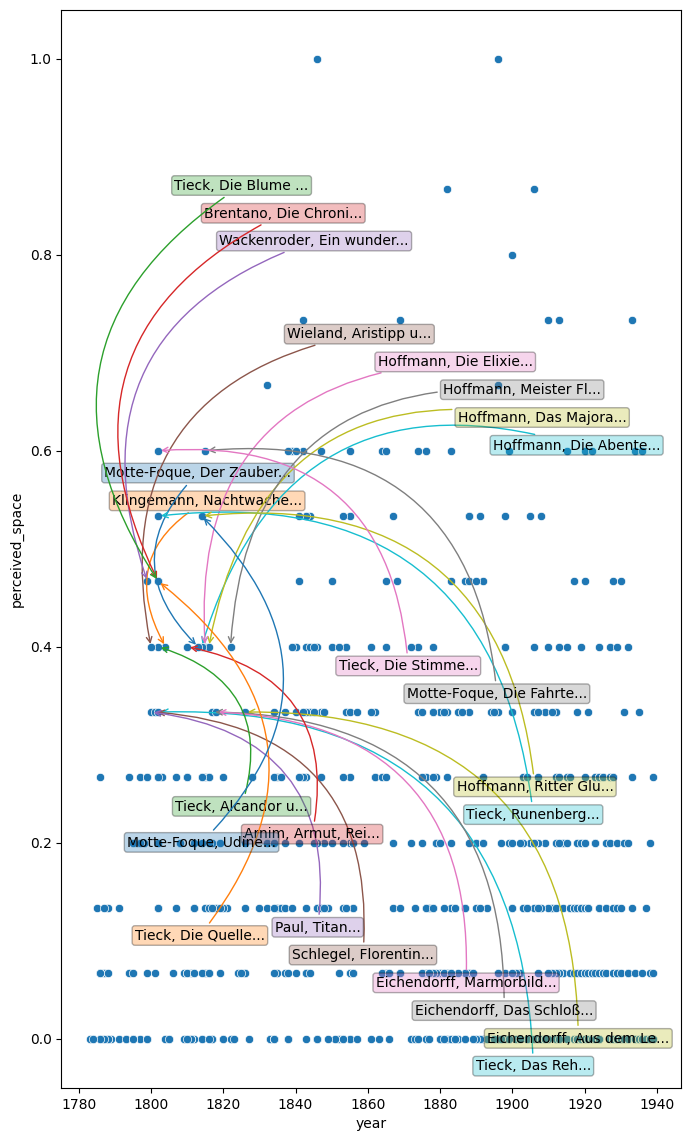

In [ ]:
color_indexer = {'action_space': 1,
 'perceived_space': 0,
 'visual_space': 2,
 'descriptive_space': 3,
 'all_space': 4}

palette = {space_type : sns.color_palette().as_hex()[i] for space_type, i in color_indexer.items()}

plot_df2 = df

plot_df2 = plot_df2.reset_index()
_canon_df = canon_df[["filename", "author_last", "title"]].set_index("filename")
plot_df2 = plot_df2.set_index("filename")

plot_df2 = plot_df2.join(_canon_df, how = "inner").reset_index()

idxs = []

fig, ax = plt.subplots(figsize=(8, 14))

xtext_coords = list(range(0,300,30)) * 10

ytext_coords = (list(range(-260,-100,20)) + list(range(100,300,20)) )* 10
ytext_coords.reverse()

from matplotlib.colors import TABLEAU_COLORS
colors = TABLEAU_COLORS
colors = list(colors.keys()) * 10


for space_type, cut_off, start_year, end_year in [#("action_space", 0.25, 1790, 1815)]:
                                                ("perceived_space", 0.27, 1790, 1830)]:
                                                    #("descriptive_space", 0.037, 1840, 1880)]
                                                #("visual_space", 0.040, 1790, 1960)]:
    
    
    ax = sns.scatterplot(ax = ax, x = plot_df2["year"], y = plot_df2[space_type], color = palette[space_type])

    idx = (plot_df2[space_type] > cut_off) 
    idx = idx & (plot_df2["year"] >= start_year) & (plot_df2["year"] <= end_year)
    idxs.append(idx)


    
    ys = plot_df2.loc[idx].copy().sort_values(space_type, ignore_index = True)
    
    for i,row in ys.iterrows():
        text = row["author_last"] + ", " + row["title"][:10] + "..."
        x = row["year"]
        y = row[space_type]
        ytext = ytext_coords.pop()
        xtext = xtext_coords.pop()
        color = colors.pop()
        ax.annotate(text, xy=(x, y), xytext=(xtext,ytext), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc=color, alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                            color=color))
